### Imports and shared

In [28]:
from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.ai.anomalydetector.models import *
from azure.core.credentials import AzureKeyCredential
import time
from datetime import datetime, timezone
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

'''
Authenticates your credentials and creates a client.
'''
key = "62d71c2d6c6341b6b038af0ae40156f3"
endpoint = "https://actsoftanomalydetector.cognitiveservices.azure.com/"

client = AnomalyDetectorClient(endpoint, AzureKeyCredential(key))


### Univariate detection

Anomaly detected at index:      3
Anomaly detected at index:      18
Change point detected at index: 20
Anomaly detected at index:      21
Anomaly detected at index:      22
Anomaly detected at index:      23
Anomaly detected at index:      24
Anomaly detected at index:      25
Change point detected at index: 27
Anomaly detected at index:      28
Anomaly detected at index:      29
Anomaly detected at index:      30
Anomaly detected at index:      31
Anomaly detected at index:      32
Anomaly detected at index:      35
Anomaly detected at index:      44


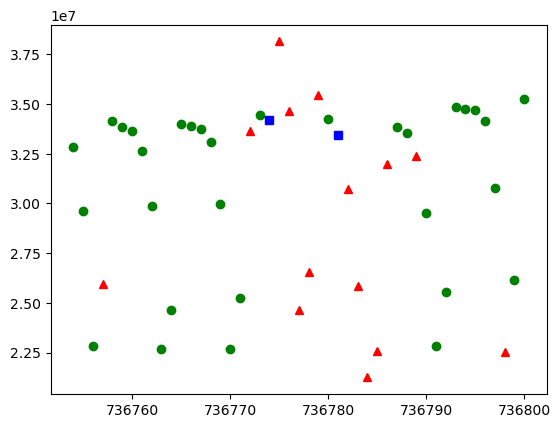

In [32]:
DATA_PATH = 'C:\\Data Science\\cognitive-services\\request-data.csv'

series = []
data_file = pd.read_csv(DATA_PATH, header=None, encoding='utf-8', date_parser=[0])
for index, row in data_file.iterrows():
    series.append(TimeSeriesPoint(timestamp=row[0], value=row[1]))

request = UnivariateDetectionOptions(series=series, granularity=TimeGranularity.DAILY)

change_point_response = client.detect_univariate_change_point(request)
anomaly_response = client.detect_univariate_entire_series(request)

date_format = "%Y-%m-%dT%H:%M:%SZ"
for i in range(len(data_file.values)):
    temp_date = datetime.strptime(data_file.values[i][0], date_format)
    temp_date_to_num = mdates.date2num(temp_date)
    date= temp_date_to_num
    if (change_point_response.is_change_point[i]):
        plt.plot(date,data_file.values[i][1], 's', color ='blue')
        print("Change point detected at index: "+ str(i))
    elif (anomaly_response.is_anomaly[i]):
        plt.plot(date,data_file.values[i][1], '^', color="red")
        print("Anomaly detected at index:      "+ str(i))
    else:
        plt.plot(date,data_file.values[i][1], 'o', color ='green')
plt.show()


### Multivariate detection

In [ ]:
time_format = "%Y-%m-%dT%H:%M:%SZ"
blob_url = "Path-to-sample-file-in-your-storage-account"  # example path: https://docstest001.blob.core.windows.net/test/sample_data_5_3000.csv
# blob_url = 'C:\\Data Science\\cognitive-services\\sample_data_5_3000.csv'

train_body = ModelInfo(
    data_source=blob_url,
    start_time=datetime.strptime("2021-01-02T00:00:00Z", time_format),
    end_time=datetime.strptime("2021-01-02T05:00:00Z", time_format),
    data_schema="OneTable",
    display_name="sample",
    sliding_window=200,
    align_policy=AlignPolicy(
        align_mode=AlignMode.OUTER,
        fill_n_a_method=FillNAMethod.LINEAR,
        padding_value=0,
    ),
)

batch_inference_body = MultivariateBatchDetectionOptions(
       data_source=blob_url,
       top_contributor_count=10,
       start_time=datetime.strptime("2021-01-02T00:00:00Z", time_format),
       end_time=datetime.strptime("2021-01-02T05:00:00Z", time_format),
   )


print("Training new model...(it may take a few minutes)")
model = client.train_multivariate_model(train_body)
model_id = model.model_id
print("Training model id is {}".format(model_id))

## Wait until the model is ready. It usually takes several minutes
model_status = None
model = None

while model_status != ModelStatus.READY and model_status != ModelStatus.FAILED:
    model = client.get_multivariate_model(model_id)
    print(model)
    model_status = model.model_info.status
    print("Model is {}".format(model_status))
    time.sleep(30)
if model_status == ModelStatus.READY:
    print("Done.\n--------------------")
    # Return the latest model id

# Detect anomaly in the same data source (but a different interval)
result = client.detect_multivariate_batch_anomaly(model_id, batch_inference_body)
result_id = result.result_id

# Get results (may need a few seconds)
r = client.get_multivariate_batch_detection_result(result_id)
print("Get detection result...(it may take a few seconds)")

while r.summary.status != MultivariateBatchDetectionStatus.READY and r.summary.status != MultivariateBatchDetectionStatus.FAILED and r.summary.status !=MultivariateBatchDetectionStatus.CREATED:
    anomaly_results = client.get_multivariate_batch_detection_result(result_id)
    print("Detection is {}".format(r.summary.status))
    time.sleep(5)
    
   
print("Result ID:\t", anomaly_results.result_id)
print("Result status:\t", anomaly_results.summary.status)
print("Result length:\t", len(anomaly_results.results))

# See detailed inference result
for r in anomaly_results.results:
    print(
        "timestamp: {}, is_anomaly: {:<5}, anomaly score: {:.4f}, severity: {:.4f}, contributor count: {:<4d}".format(
            r.timestamp,
            r.value.is_anomaly,
            r.value.score,
            r.value.severity,
            len(r.value.interpretation) if r.value.is_anomaly else 0,
        )
    )
    if r.value.interpretation:
        for contributor in r.value.interpretation:
            print(
                "\tcontributor variable: {:<10}, contributor score: {:.4f}".format(
                    contributor.variable, contributor.contribution_score
                )
            )
